In [187]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from collections import defaultdict
from tqdm import tqdm
import collections
import pickle
import re
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to /opt/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
train_df = pd.read_csv('.git/text-difficulty-prediction/dataset/WikiLarge_Train.csv')
test_df = pd.read_csv('.git/text-difficulty-prediction/dataset/WikiLarge_Test.csv')
features_aoa = pd.read_csv('.git/text-difficulty-prediction/features/AoA_51715_words.csv')
features_concrete = pd.read_csv('.git/text-difficulty-prediction/features/Concreteness_ratings_Brysbaert_et_al_BRM.txt', delimiter = '\t')
features_dale_chall = pd.read_csv('.git/text-difficulty-prediction/features/dale_chall.txt',delimiter='\t')

In [135]:
train_df

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1
...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0
416764,"However , it is becoming replaced as a method ...",0
416765,There are hand gestures in both Hindu and Budd...,0
416766,"If it is necessary to use colors , try to choo...",0


In [149]:
#make indexs
dale_chall_index = defaultdict(list)
high_aoa_index = defaultdict(list)
low_aoa_index = defaultdict(list)
#doc_index = defaultdict(dict)


In [150]:
#make indexs for test
t_dale_chall_index = defaultdict(list)
t_high_aoa_index = defaultdict(list)
t_low_aoa_index = defaultdict(list)
#t_doc_index = defaultdict(dict)


In [132]:
stemmer = PorterStemmer()
#need to provide a series or dataframe
def text_clean(text):

    cleaned_text = text.apply(lambda x: re.sub(r'\-LRB\-|\-RRB\-', '', x))
    # Tokenize
    tokens = cleaned_text.apply(word_tokenize)
    # Stem
    stemmed = tokens.apply(text_stemmer)
    # Rejoin from list to sentence
    cleaned_text = stemmed.apply(" ".join)
    # Remove non-word characters
    cleaned_text = cleaned_text.apply(lambda x: re.sub(r'\W+', ' ', x))
    
    return cleaned_text
def text_stemmer(token_text):
    stemmed_words = [stemmer.stem(word) for word in token_text]
    return stemmed_words

In [136]:
train_df['clean_text'] = text_clean(train_df['original_text'])
test_df['clean_text'] = text_clean(test_df['original_text'])

In [137]:
train_df.head()

,original_text,label,clean_text
0,There is manuscript evidence that Austen conti...,1,there is manuscript evid that austen continu t...
1,"In a remarkable comparative analysis , Mandaea...",1,In a remark compar analysi mandaean scholar sä...
2,"Before Persephone was released to Hermes , who...",1,befor persephon wa releas to herm who had been...
3,Cogeneration plants are commonly found in dist...,1,cogener plant are commonli found in district h...
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,geneva is the second most popul citi in switze...


In [6]:

# file_path = '/home/jovyan/work/docindex.pickle'

# # Open the file in read-binary mode and load the data
# with open(file_path, 'rb') as file:
#     doc_index = pickle.load(file)

In [7]:
# file_path = '/home/jovyan/work/traindf.pickle'

# # Open the file in read-binary mode and load the data
# with open(file_path, 'rb') as file:
#     merge_df = pickle.load(file)

In [138]:
#need to add concretness features
def create_doc_dict(row):
    return {
        'doc': row['clean_text'],
        'dale_chall': 0,
        'len': len(row['clean_text'].split()),
        'high_aoa': 0,
        'low_aoa': 0,
        'concretness_rating':0,
    }

# Vectorized creation of the doc_index dictionary
doc_index = 'd' + train_df.reset_index().astype(str)['index']
doc_values = train_df.apply(create_doc_dict, axis=1)

# Combine keys and values into a single dictionary
doc_index = dict(zip(doc_index, doc_values))

In [140]:
t_doc_index = 'd' + test_df.reset_index().astype(str)['index']
t_doc_values = test_df.apply(create_doc_dict, axis=1)
t_doc_index = dict(zip(doc_index, t_doc_values))

In [ ]:
features_concrete.dropna(subset=['Word','Conc.M'],inplace=True)
concrete_list = text_clean(features_concrete['Word']).tolist()
stemmed_word_counts = {}  
for idx, (word, concrete) in enumerate(zip(concrete_list,features_concrete['Conc.M'])):
    counts = stemmed_word_counts.get(word, {'sum': 0, 'count': 0})
    counts['sum'] += concrete
    counts['count'] += 1
    stemmed_word_counts[word] = counts

# Calculate the average age of acquisition for each stemmed word
average_concrete = {}
for word, counts in stemmed_word_counts.items():
    average_rate = round(counts['sum'] / counts['count'],1)
    average_concrete[word] = average_rate
    
for word, average_rate in average_concrete.items():
    print(f"{word}: {average_rate}")

In [ ]:
count_values = average_concrete.values()

# Step 2: Count the frequency of each value
count_frequency = collections.Counter(count_values)

# Step 3: Print the frequency of the counts
for count, frequency in count_frequency.items():
    print(f"Count: {count}, Frequency: {frequency}")

In [ ]:
counts = list(count_frequency.keys())
frequencies = list(count_frequency.values())

plt.bar(counts, frequencies)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Frequency of Counts')
plt.show()

In [151]:

features_aoa.dropna(subset=['Word','AoA_Kup_lem'],inplace=True)


In [152]:
aoa_list = text_clean(features_aoa['Word']).tolist()

In [153]:
stemmed_word_counts = {}  
for idx, (word, aoa) in enumerate(zip(aoa_list,features_aoa['AoA_Kup_lem'])):
    counts = stemmed_word_counts.get(word, {'sum': 0, 'count': 0})
    counts['sum'] += aoa
    counts['count'] += 1
    stemmed_word_counts[word] = counts

# Calculate the average age of acquisition for each stemmed word
average_aoa = {}
for word, counts in stemmed_word_counts.items():
    average_age = round(counts['sum'] / counts['count'])
    average_aoa[word] = average_age
    
for word, average_age in average_aoa.items():
    print(f"{word}: {average_age}")

a: 3
aardvark: 10
abacu: 9
abacus: 9
abalon: 12
abandon: 9
abas: 15
abat: 15
abattoir: 15
abbaci: 14
abbess: 15
abbey: 13
abbot: 12
abbrevi: 10
abdic: 13
abdomen: 9
abdomin: 10
abduct: 11
abductor: 11
abeam: 13
aberr: 13
abet: 12
abettor: 16
abey: 15
abhor: 14
abhorr: 12
abid: 10
abil: 9
abject: 14
abjur: 16
ablat: 13
ablaz: 11
abl: 8
abler: 8
ablest: 8
ablut: 14
abnorm: 11
aboard: 9
abod: 12
abolish: 10
abolit: 13
abolition: 12
abolitionist: 13
abomin: 12
aborigin: 14
aborn: 13
abort: 13
abortionist: 15
abound: 12
about: 5
abov: 5
aboveboard: 13
aboveground: 8
abovement: 14
abracadabra: 7
abrad: 14
abras: 12
abreact: 16
abreast: 13
abridg: 13
abroad: 10
abrog: 15
abrupt: 12
abscess: 13
abscond: 15
absenc: 8
absent: 6
absente: 12
absentmind: 11
absentminded: 10
absinth: 16
absolut: 10
absolv: 13
absorb: 9
absorpt: 11
abstain: 13
abstent: 15
abstin: 13
abstract: 12
abstractionist: 15
abstrus: 15
absurd: 12
absurdist: 13
abund: 12
abus: 9
abut: 14
abuzz: 13
abysm: 15
abyss: 13
ac: 11
aca

In [154]:

count_values = average_aoa.values()

# Step 2: Count the frequency of each value
count_frequency = collections.Counter(count_values)

# Step 3: Print the frequency of the counts
for count, frequency in count_frequency.items():
    print(f"Count: {count}, Frequency: {frequency}")

Count: 3, Frequency: 131
Count: 10, Frequency: 2892
Count: 9, Frequency: 2420
Count: 12, Frequency: 3154
Count: 15, Frequency: 1594
Count: 14, Frequency: 2481
Count: 13, Frequency: 2841
Count: 11, Frequency: 3148
Count: 16, Frequency: 1022
Count: 8, Frequency: 2012
Count: 5, Frequency: 854
Count: 7, Frequency: 1459
Count: 6, Frequency: 1230
Count: 17, Frequency: 423
Count: 18, Frequency: 173
Count: 4, Frequency: 514
Count: 21, Frequency: 2
Count: 2, Frequency: 13
Count: 20, Frequency: 16
Count: 19, Frequency: 39
Count: 25, Frequency: 1


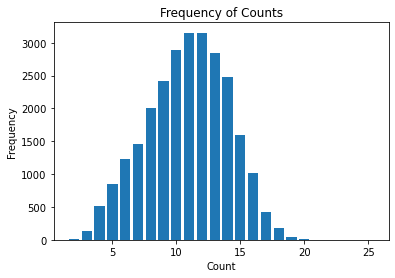

In [145]:
counts = list(count_frequency.keys())
frequencies = list(count_frequency.values())

plt.bar(counts, frequencies)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Frequency of Counts')
plt.show()

In [155]:
dale_chall = text_clean(features_dale_chall['a'])

In [156]:
#populate dale_chall index
for idx, word in enumerate(dale_chall):
     t_dale_chall_index[word]
dale_chall_list = list(dale_chall)

In [239]:
dale_chall_set = set(dale_chall_list)
aoa_set = set(aoa_list)
concrete_set = set(concrete_list)
# Function to process each document
def process_document(doc_id, doc_data):
    doc = doc_data['doc']
    words = doc.split()
    
    dale_chall_count = 0
    high_aoa_count = 0
    low_aoa_count = 0
    high_concrete_count = 0
    low_concrete_count = 0
    
    for word in words:
        if word in dale_chall_set:
            dale_chall_index[word].append(doc_id)
            dale_chall_count += 1
            
        if word in aoa_set:
            #originally set to 11
            #8 had improvments
            #7 increased rf score
            if average_aoa[word] > 7:
                high_aoa_index[word].append(doc_id)
                high_aoa_count += 1
            else:
                low_aoa_index[word].append(doc_id)
                low_aoa_count += 1
                
        if word in concrete_set:

            if average_concrete[word] >= 4:
                #high_aoa_index[word].append(doc_id)
                high_concrete_count += 1
            else:
                #low_aoa_index[word].append(doc_id)
                low_concrete_count += 1
                
    # Update doc_data
    doc_data['dale_chall'] = dale_chall_count
    doc_data['high_aoa'] = high_aoa_count
    doc_data['low_aoa'] = low_aoa_count
    doc_data['high_concrete'] = high_concrete_count
    doc_data['low_concrete'] = low_concrete_count    
    
# Vectorized application of the process_document function
for doc_id, doc_data in tqdm(doc_index.items()):
    process_document(doc_id, doc_data)

100%|██████████| 416768/416768 [00:04<00:00, 88099.07it/s] 


In [240]:
for doc_id, doc_data in tqdm(t_doc_index.items()):
    process_document(doc_id, doc_data)

100%|██████████| 119092/119092 [00:01<00:00, 94200.77it/s]


In [241]:

# Create a DataFrame from the doc_index dictionary
data = []
for doc_id, doc_data in tqdm(doc_index.items()):
    idx = doc_id[1:]
    data.append([idx, doc_data['len'], doc_data['dale_chall'], doc_data['high_aoa'], doc_data['low_aoa'],doc_data['high_concrete'],doc_data['low_concrete']])

columns_to_update = ['index', 'sent_len', 'num_dalechall', 'num_highaoa', 'num_lowaoa','num_highcon','num_lowcon']
update_df = pd.DataFrame(data, columns=columns_to_update)
# # Merge the data with the original DataFrame
train_df_full = train_df.merge(update_df, left_index=True,right_index=True)

# # Clean up the columns (drop the extra index column and rename the columns)
train_df_full.drop(columns=['index'], inplace=True)

100%|██████████| 416768/416768 [00:03<00:00, 112012.45it/s]


In [242]:
train_df_full.head()

,original_text,label,clean_text,sent_len,num_dalechall,num_highaoa,num_lowaoa
0,There is manuscript evidence that Austen conti...,1,there is manuscript evid that austen continu t...,38,22,7,22
1,"In a remarkable comparative analysis , Mandaea...",1,In a remark compar analysi mandaean scholar sä...,22,7,9,6
2,"Before Persephone was released to Hermes , who...",1,befor persephon wa releas to herm who had been...,40,29,8,31
3,Cogeneration plants are commonly found in dist...,1,cogener plant are commonli found in district h...,32,21,13,17
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,geneva is the second most popul citi in switze...,25,18,4,15


In [243]:
# Create a DataFrame from the t_doc_index dictionary
data = []
for doc_id, doc_data in tqdm(t_doc_index.items()):
    idx = doc_id[1:]
    data.append([idx, doc_data['len'], doc_data['dale_chall'], doc_data['high_aoa'], doc_data['low_aoa'],doc_data['high_concrete'],doc_data['low_concrete']])

columns_to_update = ['index', 'sent_len', 'num_dalechall', 'num_highaoa', 'num_lowaoa','num_highcon','num_lowcon']
update_df = pd.DataFrame(data, columns=columns_to_update)
#other dict names were being added, remove them
#update_df = update_df.iloc[:-4]
# # Merge the data with the original DataFrame
test_df_full = test_df.merge(update_df, left_index=True,right_index=True)

# # Clean up the columns (drop the extra index column and rename the columns)
test_df_full.drop(columns=['index','label'], inplace=True)

100%|██████████| 119092/119092 [00:00<00:00, 128058.79it/s]


In [230]:
test_df_full.head()

,id,original_text,clean_text,sent_len,num_dalechall,num_highaoa,num_lowaoa
0,0,-2011,2011,1,0,0,0
1,1,-2011,2011,1,0,0,0
2,2,-2000,2000,1,0,0,0
3,3,-1997,1997,1,0,0,0
4,4,1.636,1 636,2,0,0,0


In [170]:
# with open('train_df_full.pickle', 'wb') as f:
#     pickle.dump(train_df_full, f)

In [ ]:
# #load pickled data
# with open('train_df_full.pickle', 'rb') as f:
#     train_df_full = pickle.load(f)

In [171]:
# with open('test_df_full.pickle', 'wb') as f:
#     pickle.dump(test_df_full, f)

In [ ]:
# #load pickled data
# with open('test_df_full.pickle', 'rb') as f:
#     test_df_full = pickle.load(f)

In [244]:
X = train_df_full.copy()
X = X.drop(['original_text','clean_text'],axis=1)
y = X.pop('label')


In [245]:
X.head()

,sent_len,num_dalechall,num_highaoa,num_lowaoa
0,38,22,7,22
1,22,7,9,6
2,40,29,8,31
3,32,21,13,17
4,25,18,4,15


In [246]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [247]:
#making sure class balance is still okay
class_counts = y_train.value_counts()
class_counts

0    177224
1    177028
Name: label, dtype: int64

In [248]:
from sklearn.dummy import DummyClassifier
#dummy classifier
# Create a DummyClassifier with a 'most_frequent' strategy
dummy = DummyClassifier(strategy='most_frequent')

# Train the classifier on the training data
dummy.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.49843240130526584


In [249]:
#logistic regression on just the features we have
lr_clf = LogisticRegression(random_state=42).fit(X_train, y_train)
lr_preds = lr_clf.predict(X_val)

accuracy = accuracy_score(y_val, lr_preds)
precision = precision_score(y_val, lr_preds)
recall = recall_score(y_val, lr_preds)
f1 = f1_score(y_val, lr_preds)
roc_auc = roc_auc_score(y_val, lr_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.6249280184272826
Precision: 0.6456139058702217
Recall: 0.559095547901518
F1 Score: 0.5992479917962742
ROC AUC Score: 0.6251350653499887


In [176]:
lr_clf = LogisticRegression(random_state=42).fit(X, y)

In [179]:
X_test = test_df_full.copy()
X_test = X_test.drop(['original_text','clean_text','id'],axis=1)


lr_preds = lr_clf.predict(X_test).tolist()

,sent_len,num_dalechall,num_highaoa,num_lowaoa
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,2,0,0,0


In [182]:
#logistirc regression sumbission
df = pd.DataFrame({'id':test_df_full['id'],'label':lr_preds})
filename = 'predictions.csv'
df.to_csv(filename, index=False)

In [250]:
# Initialize the models
#rf .654 with 15/10 depth
rf_model = RandomForestClassifier(max_depth=10, random_state=42)
# gb_model = GradientBoostingClassifier(n_estimators = 200, max_depth = 15, random_state=42)


# Fit the models
rf_model.fit(X_train, y_train)
# gb_model.fit(X_train, y_train)


# Make predictions on validation for now 
rf_predictions = rf_model.predict(X_val)
# gb_predictions = gb_model.predict(X_val)


In [251]:
rf_f1 = f1_score(y_val, rf_predictions)
# gb_f1 = f1_score(y_val, gb_predictions)


print(f'F1 Score for random forest: {rf_f1}')
# print(f'F1 Score for gradient boosted forest: {gb_f1}')


F1 Score for random forest: 0.659437887670343


In [188]:
#random forest submission
rf_model.fit(X, y)
rf_preds = rf_model.predict(X_test).tolist()
df = pd.DataFrame({'id':test_df_full['id'],'label':lr_preds})
filename = 'rf_predictions.csv'
df.to_csv(filename, index=False)

RandomForestClassifier(max_depth=15, random_state=42)

In [197]:
X = train_df_full.copy()
y = X.pop('label')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [198]:
#logistic regression on tf-idf
vectorizer = TfidfVectorizer(stop_words='english',min_df = 20, max_df = 0.90)
#vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_text'])
X_val_vec = vectorizer.transform(X_val['clean_text'])

In [199]:
lr_tfidf_clf = LogisticRegression(random_state=42).fit(X_train_vec, y_train)
lr_preds = lr_tfidf_clf.predict(X_val_vec)

accuracy = accuracy_score(y_val, lr_preds)
precision = precision_score(y_val, lr_preds)
recall = recall_score(y_val, lr_preds)
f1 = f1_score(y_val, lr_preds)
roc_auc = roc_auc_score(y_val, lr_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.678194382238147
Precision: 0.6864176232499503
Recall: 0.6598418165582345
F1 Score: 0.6728674103222868
ROC AUC Score: 0.6782521021173714


In [211]:
#tfidf submission
X_test = test_df_full.copy()
X_test = X_test.drop('id',axis=1)
X_vec = vectorizer.fit_transform(X['clean_text'])
X_test_vec = vectorizer.transform(X_test['clean_text'])

lr_tfidf_clf = LogisticRegression(random_state=42).fit(X_vec, y)
lr_tfidf_preds = lr_tfidf_clf.predict(X_test_vec)
df = pd.DataFrame({'id':test_df_full['id'],'label':lr_tfidf_preds})

filename = 'tfidf_predictions.csv'
df.to_csv(filename, index=False)

In [ ]:

#not much testing down below --------


In [208]:
svd = TruncatedSVD(n_components=150)  # Specify the number of components you want to keep
X_svd = svd.fit_transform(X_train_vec)
X_svd_val = svd.transform(X_val_vec)

In [209]:
lr_svd_clf = LogisticRegression(random_state=42).fit(X_svd, y_train)
lr_preds = lr_svd_clf.predict(X_svd_val)

accuracy = accuracy_score(y_val, lr_preds)
precision = precision_score(y_val, lr_preds)
recall = recall_score(y_val, lr_preds)
f1 = f1_score(y_val, lr_preds)
roc_auc = roc_auc_score(y_val, lr_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.6007422099942414
Precision: 0.6100936381162214
Recall: 0.5651868860824085
F1 Score: 0.5867823322958745
ROC AUC Score: 0.6008540335418461


In [203]:
#logistic regression on both tf-idf and features
X_additional = X_train[['sent_len','num_dalechall','num_highaoa','num_lowaoa']].values

# # Concatenate the arrays together
X_train_arr = np.concatenate((X_svd, X_additional), axis=1)

In [204]:
X_additional_val = X_val[['sent_len','num_dalechall','num_highaoa','num_lowaoa']].values

# # Concatenate the arrays together
X_val_arr = np.concatenate((X_svd_val, X_additional_val), axis=1)

In [ ]:
#create pipeline with .yaml for easy git changes

In [205]:
lr_arr_clf = LogisticRegression(random_state=42).fit(X_train_arr, y_train)
lr_preds = lr_arr_clf.predict(X_val_arr)

accuracy = accuracy_score(y_val, lr_preds)
precision = precision_score(y_val, lr_preds)
recall = recall_score(y_val, lr_preds)
f1 = f1_score(y_val, lr_preds)
roc_auc = roc_auc_score(y_val, lr_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.6460266171860004
Precision: 0.6608107637073443
Recall: 0.6046051792320449
F1 Score: 0.6314597385294363
ROC AUC Score: 0.6461568900011316


In [212]:
# Initialize the models

rf_model = RandomForestClassifier(max_depth = 10, random_state=42)
#gb_model = GradientBoostingClassifier(n_estimators = 200, max_depth = 15, random_state=42)


# Fit the models
rf_model.fit(X_train_arr, y_train)
#gb_model.fit(X_train_arr, y_train)


# Make predictions on validation for now 
rf_predictions = rf_model.predict(X_val_arr)
#gb_predictions = gb_model.predict(X_val_arr)

In [213]:
rf_f1 = f1_score(y_val, rf_predictions)
#gb_f1 = f1_score(y_val, gb_predictions)


print(f'F1 Score for random forest: {rf_f1}')
#print(f'F1 Score for gradient boosted forest: {gb_f1}')
#pickle these models if they are good

F1 Score for random forest: 0.6833227572569102


In [ ]:

"""
This file contains "Age of Acquisition" (AoA) estimates for about 51k English words, which refers to the approximate age (in years) when a word was learned. Early words, being more basic, have lower average AoA.

The main columns you will be interested in are "Word" and "AoA_Kup_lem". But the others may be useful too.

Word :: The word in question
Alternative.spelling :: if the Word may be spelled frequently in another form	
Freq_pm	:: Freq of the Word in general English (larger -> more common)
Dom_PoS_SUBTLEX	:: Dominant part of speech in general usage
Nletters :: number of letters 
Nphon :: number of phonemes
Nsyll :: number of syllables
Lemma_highest_PoS :: the "lemmatized" or "root" form of the word (in the dominant part of speech. e.g. The root form of the verb "abates" is "abate".
AoA_Kup	:: The AoA from a previous study by Kuperman et al.
Perc_known :: Percent of people who knew the word in the Kuperman et al. study
AoA_Kup_lem :: Estimated AoA based on Kuperman et al. study lemmatized words. THIS IS THE MAIN COLUMN OF INTEREST.
Perc_known_lem	:: Estimated percentage of people who would know this form of the word in the Kuperman study.
AoA_Bird_lem :: AoA reported in previous study by Bird (2001) 
AoA_Bristol_lem	:: AoA reported in previous study from Bristol Univ. (2006)
AoA_Cort_lem :: AoA reported in previous study by Cortese & Khanna (2008)
AoA_Schock :: AoA reported in previous study by Schock (2012)

"""
features_aoa.head()

In [ ]:
"""
This file contains concreteness ratings for 40 thousand English lemma words gathered via Amazon Mechanical Turk. The ratings come from a larger list of 63 thousand words and represent all English words known to 85% of the raters.

The file contains eight columns:
1. The word
2. Whether it is a single word or a two-word expression 
3. The mean concreteness rating
4. The standard deviation of the concreteness ratings
5. The number of persons indicating they did not know the word
6. The total number of persons who rated the word
7. Percentage participants who knew the word
8. The SUBTLEX-US frequency count (on a total of 51 million; Brysbaert & New, 2009) 
9. The dominant part-of-speech usage

"""
features_concrete.head()

In [ ]:
"""
This is the Dale Chall 3000 Word List, which is one definition of words that are considered "basic" English.
A summary is at https://www.readabilityformulas.com/articles/dale-chall-readability-word-list.php

"""
features_dale_chall.head()